# Imports

In [11]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import pickle

# Testing on one frame

## Video indices

In [12]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 152, 153, 155, 156, 166, 167, 168, 171, 198]


## Functions:
- get_file_path
- extract_landmarks
- draw_landmarks_on_image

In [13]:
# function to get the file path, according to the label, up_down and video_index
def get_file_path(label, up_down, video_index):

    if label == 'correct':
        image_dir = 'images/correct_seq'
        corr_inc = 'cor'
    elif label == 'incorrect':
        image_dir = 'images/wrong_seq'
        corr_inc = 'inc'
    else:
        print('Label not found')
        exit()

    # Constructing the file pattern using the video index
    file_pattern = f'{corr_inc}_{up_down}_{video_index}_*.jpg'
    file_pattern_path = os.path.join(image_dir, file_pattern)
    # Finding the file that matches the pattern
    matching_files = glob.glob(file_pattern_path)
    # In case there is more than one
    if len(matching_files) > 1:
        print('More than one file found')
        exit()
    # But, there should be only one
    file_path = matching_files[0]
    
    return file_path 

In [14]:
# function to get the landmarks from a frame
def extract_landmarks(this_image_path, model_path='pose_landmarker_heavy.task'):

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=VisionRunningMode.IMAGE)

    with PoseLandmarker.create_from_options(options) as landmarker:
        # Load the input image from an image file.
        image = mp.Image.create_from_file(this_image_path)

        # Perform pose landmarking on the provided single image.
        # The pose landmarker must be created with the image mode.
        pose_landmarker_result = landmarker.detect(image)

        pose_landmarks_list = pose_landmarker_result.pose_landmarks

        # Loop through the detected poses to get the landmarks.
        pose_landmarks = None
        if pose_landmarks_list:
            pose_landmarks = pose_landmarks_list[0]

    return pose_landmarks, pose_landmarker_result

In [15]:
# function to display the landmarks on top of the image
def draw_landmarks_on_image(rgb_image, detection_result, exclude_numbers=[]):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=4),
            mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=2)
        )

        # Draw landmark numbers on the image.
        for i, landmark in enumerate(pose_landmarks):
            if i not in exclude_numbers:  # only number the landmark if it's not in the exclusion list
                cv2.putText(annotated_image, str(i), (int(landmark.x * rgb_image.shape[1]), int(landmark.y * rgb_image.shape[0])),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return annotated_image

In [16]:
# using the get_file_path and extract_landmarks functions
image_path = get_file_path('correct', 'up', video_index_corr[1])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

# this is how we can access the landmarks coordinates
pose_landmarks[0]


NormalizedLandmark(x=0.7530348300933838, y=0.6043741106987, z=-0.0010913939913734794, visibility=0.9996840953826904, presence=0.9998422861099243)

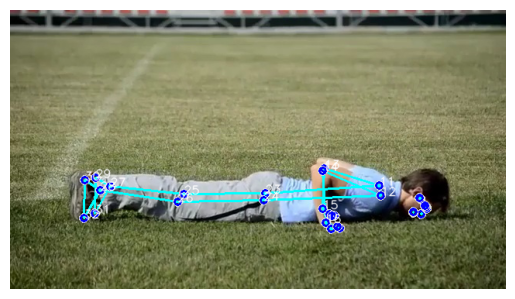

In [17]:
image_path = get_file_path('correct', 'down', video_index_corr[20])
pose_landmarks, pose_landmarker_result = extract_landmarks(image_path)

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
annotated_image = draw_landmarks_on_image(image, pose_landmarker_result, exclude_numbers=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 18, 19, 20, 21, 22])
plt.imshow(annotated_image)
plt.axis('off')  # Turn off axis
plt.show()



## Functions:
- center_landmarks (on one point, on centroid and on the average of two points)
- draw_landmarks_on_blank_canvas

In [18]:
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose a specific landmark to be the center (e.g., landmark #0)
    center_landmark_index = 24

    # Translate the landmarks so that the center landmark is at (0.5, 0.5)
    centered_landmarks = landmarks_array - landmarks_array[center_landmark_index] + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

# center_landmarks, but with centroid
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Calculate the centroid of the landmarks
    centroid = np.mean(landmarks_array, axis=0)

    # Translate the landmarks so that the centroid is at (0.5, 0.5)
    centered_landmarks = landmarks_array - centroid + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks

# instead, center_landmarks with the mean point of 2 landmarks
def center_landmarks(pose_landmarks):
    # Convert landmarks to numpy array
    landmarks_array = np.array([[landmark.x, landmark.y] for landmark in pose_landmarks])

    # Choose two specific landmarks to be the center (e.g., landmark #0 and #1)
    center_landmark_indices = [23, 24]

    # Calculate the centroid of the landmarks
    centroid = np.mean(landmarks_array[center_landmark_indices], axis=0)

    # Translate the landmarks so that the centroid is at (0.5, 0.5)
    centered_landmarks = landmarks_array - centroid + 0.5

    # Convert the landmarks back to their original format
    new_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y) for x, y in centered_landmarks]

    return new_landmarks


In [19]:
def draw_landmarks_on_blank_canvas(landmarks, image_size=500, circle_radius=5, line_width=1):
    # Create a blank canvas
    canvas = np.ones((image_size, image_size, 3), dtype=np.uint8) * 255

    # Create landmark list protobuf from landmarks
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
        landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in landmarks
    ])

    # Draw landmarks on the canvas
    mp.solutions.drawing_utils.draw_landmarks(
        canvas,
        pose_landmarks_proto,
        mp.solutions.pose.POSE_CONNECTIONS,
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=circle_radius),
        mp.solutions.drawing_utils.DrawingSpec(color=(0, 255, 255), thickness=line_width, circle_radius=2)
    )

    

    return canvas

NameError: name 'new_landmarks' is not defined

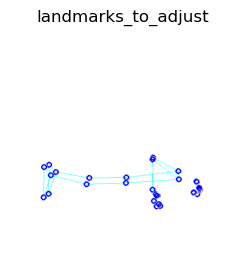

In [20]:
# Display landmarks_adjusted
canvas_adjusted = draw_landmarks_on_blank_canvas(pose_landmarks)
plt.subplot(1, 2, 1)
plt.imshow(canvas_adjusted)
plt.title('landmarks_to_adjust')
plt.axis('off')

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(new_landmarks)
plt.subplot(1, 2, 2)
plt.imshow(canvas_new)
plt.title('new_landmarks')
plt.axis('off')

plt.show()

## Function:
- normalize_landmarks

In [21]:
def normalize_landmarks(landmarks_tba, landmarks_rot, connections):
    # Convert landmarks to numpy arrays for easier manipulation
    landmarks_tba_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_tba])
    landmarks_rot_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks_rot])

    # Copy landmarks_tba_array to new_landmarks
    new_landmarks = np.copy(landmarks_tba_array)

    # Create an array to keep track of which landmarks have been updated
    updated_landmarks = [False]*len(landmarks_tba)

    # For each connection, adjust the length of the line segment in landmarks_tba to match that in landmarks_rot
    for conn in connections:
        start, end = conn
        # Use updated coordinates for the start point if available
        start_point = new_landmarks[start] if updated_landmarks[start] else landmarks_tba_array[start]

        # Calculate the vector for the line segment in landmarks_tba using original coordinates
        vec_tba = landmarks_tba_array[end] - landmarks_tba_array[start]

        # Calculate the length of the line segment in landmarks_rot
        length_rot = np.linalg.norm(landmarks_rot_array[end] - landmarks_rot_array[start])

        # Compute the direction of the line segment in landmarks_tba
        direction_tba = vec_tba / np.linalg.norm(vec_tba)

        # Compute the end point of the new line segment
        new_landmarks[end] = start_point + direction_tba * length_rot

        # Mark the end landmark as updated
        updated_landmarks[end] = True

    # Convert new_landmarks back to the list of landmark_pb2.NormalizedLandmark
    new_landmarks_pb = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in new_landmarks]

    return new_landmarks_pb


In [22]:
# connections, i.e. order by which we will normalize the landmarks
connections = [
    (23, 24), (23, 11), (24, 12), 
    (11, 13), (12, 14), (13, 15), 
    (14, 16), (15, 17), (16, 18),
    (15, 19), (16, 20), (15, 21),
    (16, 22), (23, 25), (24, 26), 
    (25, 27), (26, 28), (27, 29),
    (28, 30), (27, 31), (28, 32), 
    (11, 0), (12, 0), (0, 1),
    (0, 4), (1, 2), (2, 3),
    (4, 5), (5, 6), (0, 7),
    (0, 8), (2, 7), (5, 8),
    (0, 9), (0, 10)
]


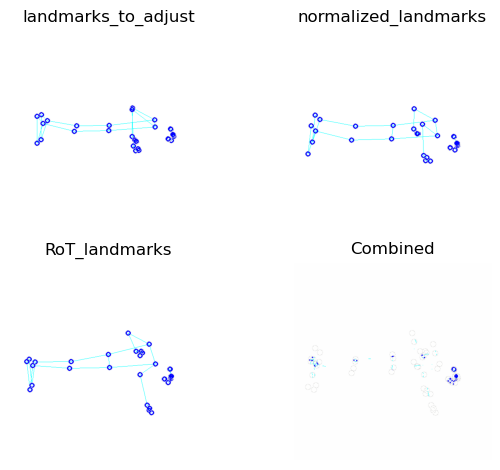

In [23]:
# checking the results of the normalization

# Get the landmarks for the RoT image
RoT_image_path = get_file_path('correct', 'down', video_index_corr[1])
RoT_pose_landmarks, RoT_pose_landmarker_result = extract_landmarks(RoT_image_path)
RoT_landmarks = center_landmarks(RoT_pose_landmarks)

# Get the landmarks for the image to adjust
to_adjust_image_path = get_file_path('correct', 'down', video_index_corr[20])
to_adjust_pose_landmarks, to_adjust_pose_landmarker_result = extract_landmarks(to_adjust_image_path)
to_adjust_landmarks = center_landmarks(to_adjust_pose_landmarks)

# Normalize the landmarks
normalized_landmarks = normalize_landmarks(to_adjust_landmarks, RoT_landmarks, connections)

# Display landmarks_to_adjust
canvas_to_adjust = draw_landmarks_on_blank_canvas(to_adjust_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(2, 2, 1)
plt.imshow(canvas_to_adjust)
plt.title('landmarks_to_adjust')
plt.axis('off')

# Display new_landmarks
canvas_new = draw_landmarks_on_blank_canvas(normalized_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(2, 2, 2)
plt.imshow(canvas_new)
plt.title('normalized_landmarks')
plt.axis('off')


# Display the RoT landmarks
canvas_RoT = draw_landmarks_on_blank_canvas(RoT_landmarks, image_size=500, circle_radius=5, line_width=1)
plt.subplot(2, 2, 3)
plt.imshow(canvas_RoT)
plt.title('RoT_landmarks')
plt.axis('off')

# Display both new_landmarks and RoT_landmarks on top of each other, with connections
canvas_combined = canvas_new + canvas_RoT  # Add both canvases together
plt.subplot(2, 2, 4)
plt.imshow(canvas_combined)
plt.title('Combined')
plt.axis('off')




plt.tight_layout()
plt.show()


# Now working on all images

## Video indices

In [111]:
# video indices

video_index_corr = [1, 2, 3, 4, 5, 6, 7, 47, 78, 79, 80, 83, 85, 100, 101, 102, 113, 114, 115, 116, 127, 129, 131, 132, 133
                , 134, 135, 136, 137, 138, 140, 141, 142, 144, 146, 147, 148, 162, 163, 164, 165, 173, 174, 175, 177, 178, 186, 187, 188, 197]
# no 176 after all

video_index_incorr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 36, 37, 42, 44,
                46, 55,56,57,58,81,104,105, 107, 108, 110, 149, 150, 151, 153, 155, 156, 166, 167, 168, 171, 198] # took out 152, mediapipe couldn't find landmarks, idky


## For loop on all frames of a certain labeled position

In [120]:
# Establishing which frame position we want, manually.
up_down = 'down' # 'up' or 'down'

# Establishing which label we want, manually.
label = 'correct' # 'correct' or 'incorrect'

if label == 'correct':
    video_indices = video_index_corr
elif label == 'incorrect':
    video_indices = video_index_incorr
else:
    print('Label not found')
    exit()

# Prepare variables to store sum of landmarks and count of images
sum_landmarks = None
image_count = 0

for video_index in video_indices:
    file_path = get_file_path(label, up_down, video_index)
    # Load the image
    image = cv2.imread(file_path)
    # Get landmarks from image
    landmarks = extract_landmarks(file_path)[0]
    # Convert landmarks to numpy array for easier manipulation
    landmarks_array = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])

    # Add landmarks to sum
    if sum_landmarks is None:
        sum_landmarks = landmarks_array
    else:
        sum_landmarks += landmarks_array

    # Increment count of images
    image_count += 1

    print(f'Processed image {image_count} of {len(video_indices)}', end='\r')

# Calculate average landmarks
avg_landmarks_array = sum_landmarks / image_count

# Convert average_landmarks back to the list of landmark_pb2.NormalizedLandmark
avg_landmarks = [landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for x, y, z in avg_landmarks_array]



In [119]:
'''
import pickle

# define a filename to save the data
filename = 'avg_landmarks_C_D.pkl'

# open the file in write binary mode
with open(filename, 'wb') as f:
    # dump the avg_landmarks object into the file
    pickle.dump(avg_landmarks, f)
'''


In [ ]:
# opening the average landmarks file

filename = 'avg_landmarks_C_U.pkl'
#filename = 'avg_landmarks_C_D.pkl'
#filename = 'avg_landmarks_I_U.pkl'
#filename = 'avg_landmarks_I_D.pkl'

with open(filename, 'rb') as f:
    # load the object from the file
    avg_landmarks = pickle.load(f)


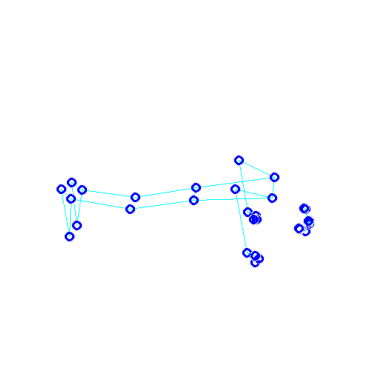

In [46]:
# displaying the average landmarks
avg_landmarks = center_landmarks(avg_landmarks)
canvas_avg = draw_landmarks_on_blank_canvas(avg_landmarks)
plt.imshow(canvas_avg)
plt.axis('off')
plt.show()